# Part A - (1) Feature Extraction
The code has been modified to split the data into 3 sets: Training (70%), Calibration (15%) and Testing (15%) using sklearn's test_train_split function.

In [ ]:
import torch
import timm
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
from tqdm import tqdm
import pandas as pd
import os

# 1. Load pretrained Vision Transformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit = timm.create_model("vit_base_patch16_224", pretrained=True).to(device)
vit.eval() # disable dropout, etc.

# 2. Define preprocessing consistent with ImageNet training
preprocess = transforms.Compose([
transforms.Resize(256),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize(
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225]
),
])

# 3. Directory containing CelebA images (modify path)
image_dir = "/home/arty/projects/cs342_dataset/img_align_celeba"
image_list = sorted(os.listdir(image_dir))[:20000] # sample subset

# Get labeled attributes from dataset
attr_file = "/home/arty/projects/cs342_dataset/list_attr_celeba.csv"
attr_df = pd.read_csv(attr_file)

# Split images into train (70%). calib (15%), test (15%)
train_set, remaining_set = train_test_split(
    image_list, 
    test_size=0.30, 
    random_state=42, # Use a fixed random_state for reproducibility
    shuffle=True
)
calib_set, test_set = train_test_split(
    remaining_set, 
    test_size=0.50, # 50% of the remaining 30% = 15% of the total
    random_state=42, # Using the same random_state is good practice
    shuffle=True
)

sets = [train_set, calib_set, test_set]

# 4. Extract embeddings
for split_name, image_list in zip(["train", "calib", "test"], sets):
    print(f"Processing {split_name} set with {len(image_list)} images...")

    all_features = []
    with torch.no_grad():
        for fname in tqdm(image_list):
            img = Image.open(os.path.join(image_dir, fname)).convert("RGB")
            x = preprocess(img).unsqueeze(0).to(device)
            features = vit.forward_features(x)[:, 0, :] # shape: (1, 768)
            all_features.append(features.cpu().numpy())
    all_features = np.concatenate(all_features, axis=0)

    # Add 'Smiling' class label as the last column
    smiling_labels = []
    for fname in image_list:
        index = int(fname.split('.')[0]) 
        smiling_label = 1 if attr_df.at[index, 'Smiling'] == 1 else 0
        smiling_labels.append(smiling_label)
    smiling_labels = np.array(smiling_labels).reshape(-1, 1)
    all_features = np.hstack((all_features, smiling_labels))

    print("Feature matrix shape:", all_features.shape) # e.g. (20000, 768 + 1)

    # 5. Save for later use
    np.save(f"celeba_vit_embeddings_{split_name}.npy", all_features)

# Part A - (2) Train Classifiers
Implement a Naive Bayes classifier to predict the Smiling attribute
(1 = smiling, 0 = not smiling) and report test accuracy. The Naive Bayes classifier should
be implemented by you and not be a call to a library function. The features here
are numerical (not categorical). So conditioned on the label, model each feature as an
independent Gaussian. Your algorithm should estimate the mean and variance of each of
these Gaussians, using the training data set

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from math import exp, sqrt, log, pi

train_data = pd.DataFrame(np.load("./celeba_vit_embeddings_train.npy"))
train_data.head()

num_features = train_data.shape[1] - 1

# First separate the data by class
pos_df = train_data[train_data[num_features]==1]
neg_df = train_data[train_data[num_features]==0]

# Now we calculate the mean and std deviation for each feature in both classes
pos_std_devs = pos_df.std()
pos_means = pos_df.mean()
neg_std_devs = neg_df.std()
neg_means = neg_df.mean()

# Calculate PDF for a given input feature vector
def calc_probs(vector):
    total_rows = train_data.shape[0]
    
    # Prior probabilities
    log_pos_prior = np.log(pos_df.shape[0] / total_rows)
    log_neg_prior = np.log(neg_df.shape[0] / total_rows)
    
    # Vectorized Gaussian log probability calculation
    def gaussian_log_prob(vector, means, stddevs):
        # Add small epsilon to avoid zero stddev
        stddevs = np.where(stddevs == 0, 1e-9, stddevs)
        return -0.5 * np.log(2 * pi) - np.log(stddevs) - ((vector - means) ** 2) / (2 * stddevs ** 2)
    
    # Calculate log probabilities for all features
    pos_log_probs = gaussian_log_prob(vector[:num_features], pos_means[:num_features], pos_std_devs[:num_features])
    neg_log_probs = gaussian_log_prob(vector[:num_features], neg_means[:num_features], neg_std_devs[:num_features])
    
    # Sum all feature log probabilities and add priors
    log_pos_prob = log_pos_prior + np.sum(pos_log_probs)
    log_neg_prob = log_neg_prior + np.sum(neg_log_probs)
    
    return log_pos_prob, log_neg_prob
    
# Run predictions on the testing set
test_data = pd.DataFrame(np.load("./celeba_vit_embeddings_test.npy"))
y_true = test_data.iloc[:, num_features].values
X_test = test_data.iloc[:, :num_features].values

preds = []
for i in range(X_test.shape[0]):
    log_pos, log_neg = calc_probs(X_test[i])
    preds.append(1 if log_pos > log_neg else 0)

preds = np.array(preds)

# Compute accuracy
accuracy = np.mean(preds == y_true)
print(f"Test Accuracy: {accuracy:.4f}")

# Optional: show confusion matrix
cm = confusion_matrix(y_true, preds)
print("Confusion matrix:")
print(cm)

Test Accuracy: 0.7343
Confusion matrix:
[[2168  667]
 [ 130   35]]


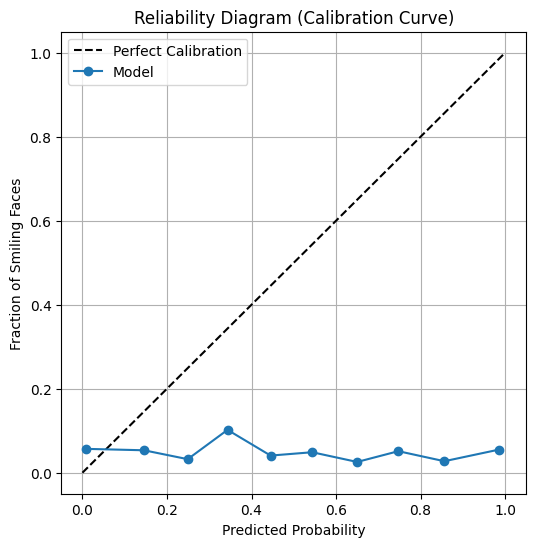

Expected Calibration Error (ECE): 0.2528


In [11]:
import matplotlib.pyplot as plt

# Compute predicted probabilities on calibration (test) set
probs = []
for i in range(X_test.shape[0]):
    log_pos, log_neg = calc_probs(X_test[i])
    
    # Convert log-probs to probability (numerically stable)
    max_log = max(log_pos, log_neg)
    pos_prob = np.exp(log_pos - max_log)
    neg_prob = np.exp(log_neg - max_log)
    prob = pos_prob / (pos_prob + neg_prob)
    
    probs.append(prob)

probs = np.array(probs)

# Reliability diagram computation
num_bins = 10
bins = np.linspace(0.0, 1.0, num_bins + 1)
bin_indices = np.digitize(probs, bins) - 1

bin_centers = []
bin_true_frac = []
bin_pred_mean = []

for i in range(num_bins):
    bin_mask = bin_indices == i
    if np.sum(bin_mask) > 0:
        bin_true_frac.append(np.mean(y_true[bin_mask]))  # actual smiling fraction
        bin_pred_mean.append(np.mean(probs[bin_mask]))   # avg predicted prob
        bin_centers.append((bins[i] + bins[i+1]) / 2)

# Plot reliability diagram
plt.figure(figsize=(6,6))
plt.plot([0,1], [0,1], 'k--', label="Perfect Calibration")
plt.plot(bin_pred_mean, bin_true_frac, 'o-', label="Model")
plt.xlabel("Predicted Probability")
plt.ylabel("Fraction of Smiling Faces")
plt.title("Reliability Diagram (Calibration Curve)")
plt.legend()
plt.grid(True)
plt.show()

# Optional: Expected Calibration Error (ECE)
ece = np.sum([
    np.abs(bin_true_frac[i] - bin_pred_mean[i]) * np.sum(bin_indices == i) / len(probs)
    for i in range(len(bin_true_frac))
])
print(f"Expected Calibration Error (ECE): {ece:.4f}")